<a href="https://colab.research.google.com/github/eshaandinesh/Colab/blob/main/Transfer_Learning_with_ResNet50_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Spark session using Pyspark Library for computing real-time, large-scale data processing.

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=3a6eef884ef395794fcb3bb76c665fe19ccbf052c612f91887c78c2b5cc83f44
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("JSON Creation").getOrCreate()


Residual Neural Network is used: **ResNet**. The task is to transfer the learning from a ResNet50, trained with Imagenet dataset, to a model that classifies flower images.

In [ ]:
!pip install split-folders matplotlib opencv-python spicy

**Librairies installation and import**

In [ ]:
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

**USE CASE: Flower Classification**
To classify flower images, the Flower Classification dataset will be used. It is available on Kaggle.

Contains information from Flower Classification, which is made available here under the CC0: Public Domain.

The dataset contains 5 types of flowers:

daisy

dandelion

roses

sunflowers

tulips

**Data preprocessing**

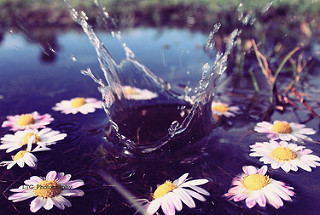

In [ ]:
img_daisy = image.load_img("/content/drive/MyDrive/flower_photos/test/daisy/10172379554_b296050f82_n.jpg")
img_daisy

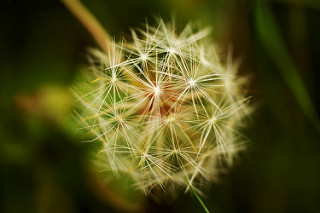

In [ ]:
# dandelion
img_dandelion = image.load_img("/content/drive/MyDrive/flower_photos/train/dandelion/10043234166_e6dd915111_n.jpg")
img_dandelion

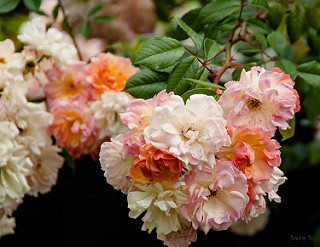

In [ ]:
# roses
img_roses = image.load_img("/content/drive/MyDrive/flower_photos/validation/roses/12240577184_b0de0e53ea_n.jpg")
img_roses

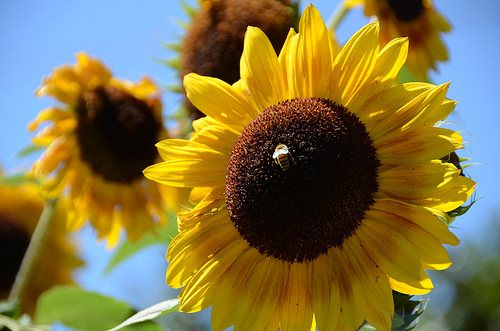

In [ ]:
# sunflowers
img_sunflowers = image.load_img("/content/drive/MyDrive/flower_photos/test/sunflowers/20342824594_9740b7b160.jpg")
img_sunflowers

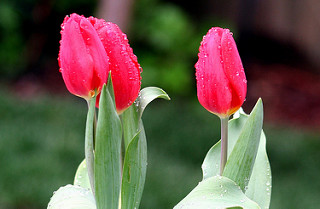

In [ ]:
# tulips
img_tulips = image.load_img("/content/drive/MyDrive/flower_photos/train/tulips/100930342_92e8746431_n.jpg")
img_tulips

Split data to use a ResNet model

By using a ResNet model, your dataset has to be split as follow:


If this is not the case for your image classification dataset, follow the steps below.


# split data in a new folder named data-split
splitfolders.ratio("Flowers/flowers", output="/Flowers/flower-split", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)
Copying files: 3669 files
[00:01, 1985.14 files/s]

**Create Keras data generators**

In [ ]:
datagen = ImageDataGenerator()

In [ ]:
# define classes name
class_names = ['daisy','dandelion','roses','sunflowers','tulips']

In [ ]:
# training data
train_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/flower_photos/train/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 3540 images belonging to 5 classes.


In [ ]:
# validation data
valid_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/flower_photos/validation/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 80 images belonging to 5 classes.


In [ ]:
# test data
test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/flower_photos/test/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 50 images belonging to 5 classes.


**Build the model**

In [ ]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

**Train the model**

Adam optimizer is used to train the model over 10 epochs. It is enough by using Transfer Learning.

The loss is calculated with the sparse_categorical_crossentropy function.

In [ ]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/flower_photos')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# launch the training
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

Epoch 1/10
111/111 [==============================] - 721s 6s/step - loss: 0.3391 - accuracy: 0.8952 - val_loss: 0.3691 - val_accuracy: 0.8750
Epoch 2/10
111/111 [==============================] - 17s 148ms/step - loss: 0.3313 - accuracy: 0.8963 - val_loss: 0.4500 - val_accuracy: 0.8875
Epoch 3/10
111/111 [==============================] - 17s 148ms/step - loss: 0.3009 - accuracy: 0.9088 - val_loss: 0.3273 - val_accuracy: 0.9000
Epoch 4/10
111/111 [==============================] - 17s 148ms/step - loss: 0.3238 - accuracy: 0.8975 - val_loss: 0.3727 - val_accuracy: 0.8625
Epoch 5/10
111/111 [==============================] - 17s 152ms/step - loss: 0.2692 - accuracy: 0.9192 - val_loss: 0.4346 - val_accuracy: 0.8750
Epoch 6/10
111/111 [==============================] - 17s 154ms/step - loss: 0.2415 - accuracy: 0.9266 - val_loss: 0.3139 - val_accuracy: 0.8750
Epoch 7/10
111/111 [==============================] - 17s 149ms/step - loss: 0.2393 - accuracy: 0.9237 - val_loss: 0.3128 - val_accu

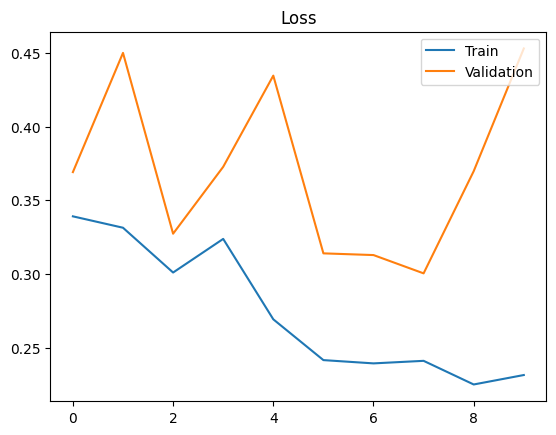

In [ ]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

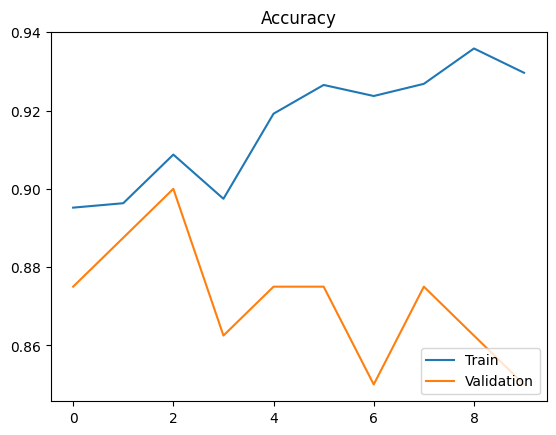

In [ ]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

**Evaluate the model**

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

2/2 [==============================] - 6s 6s/step - loss: 1.4351 - accuracy: 0.8000
The test loss is:  1.4351266622543335
The best accuracy is:  80.0000011920929


**Test the model on a new image**

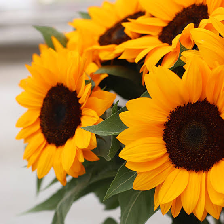

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/sunflowers.jfif', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array])
img

In [ ]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 2s 2s/step
[[1.0995171e-12 2.1431695e-10 2.0564217e-13 1.0000000e+00 3.6747015e-11]]


In [ ]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[3]


In [ ]:
# transform classes number into classes name
class_names[class_id.item()]

'sunflowers'

In [ ]:
model.save('/content/drive/MyDrive/flower_photos')

In [ ]:
spark.stop()